# PPO Report (Wind Enabled)

This notebook loads a pre-trained model and runs evaluation and visualization.
No training is required — just place the model `.zip` file in the expected path and run all cells.

---

## 1. Introduction

Deep Reinforcement Learning (DRL) has become a central paradigm for solving complex sequential decision‑making problems, particularly those involving continuous state spaces, stochastic dynamics, and delayed rewards. Among the wide range of DRL algorithms, Deep Q‑Network (DQN) and Proximal Policy Optimization (PPO) represent two fundamentally different approaches: value‑based learning and policy‑based learning. Comparing these two algorithms provides valuable insight into how different learning mechanisms behave under the same environment conditions.

In this project, we investigate the performance of DQN and PPO in the LunarLander‑v3 environment from Gymnasium. This environment simulates the control of a lunar lander that must descend and touch down smoothly within a designated landing zone. The agent receives an 8‑dimensional continuous state vector and must choose among four discrete actions, making the task suitable for both value‑based and policy‑based methods. The environment includes dense rewards, penalties for fuel consumption, and strong negative rewards for crashes, creating a challenging control problem that requires stability, precision, and efficient exploration.

The goal of this work is to train, evaluate, and compare DQN and PPO under controlled experimental conditions. We analyse their learning curves, sample efficiency, stability across multiple random seeds, and qualitative behaviour through recorded simulations. Additionally, we examine theoretical aspects such as overestimation bias in DQN, the role of clipping and Generalized Advantage Estimation (GAE) in PPO, and the differences between ε‑greedy and entropy‑driven exploration.

By combining quantitative metrics with qualitative observations, this study aims to provide a comprehensive understanding of how DQN and PPO behave in the LunarLander‑v3 environment, highlighting their strengths, limitations, and the impact of hyperparameter choices on the final performance.

## 2. Environment Analysis

### 2.1 State Space

The LunarLander‑v3 environment provides an 8‑dimensional continuous state vector describing the physical configuration of the lander at each timestep:
1. Horizontal position (x) relative to the landing zone  
2. Vertical position (y) above the ground  
3. Horizontal velocity (vx)  
4. Vertical velocity (vy)  
5. Lander angle (θ)  
6. Angular velocity (ω)  
7. Left leg contact indicator (0 or 1)  
8. Right leg contact indicator (0 or 1)

These variables allow the agent to infer its location, orientation, stability, and motion, which are essential for controlling the descent.

### 2.2 Action Space

The action space is discrete with four possible actions:
0 — Do nothing  
1 — Fire left thruster (pushes the lander to the right)  
2 — Fire main thruster (reduces vertical speed)  
3 — Fire right thruster (pushes the lander to the left)

These actions allow the agent to control both horizontal movement and vertical descent.

### 2.3 Reward Function

The reward function is dense and designed to encourage smooth and stable landings while penalizing unsafe or inefficient behaviour.

**Positive rewards include:**
- Moving closer to the landing zone  
- Reducing horizontal and vertical velocity  
- Maintaining a stable angle  
- Each leg touching the ground (+10 each)  
- Successful landing (+100 to +140)

**Penalties include:**
- High velocities  
- Large tilt angles  
- Excessive use of the main thruster (fuel cost)  
- Crashes (around −100)

A score of **200 or higher** typically indicates a successful landing.

### 2.4 Termination Rules

An episode terminates when one of the following occurs:
1. **Successful landing** within the designated zone  
2. **Crash** due to excessive speed or unstable angle  
3. **Leaving the screen boundaries**  
4. **Reaching the maximum number of steps** allowed by the environment

These termination conditions apply equally to both PPO and DQN agents.


## 3. Experimental Setup

This section describes the training and evaluation methodology used to compare DQN and PPO in the LunarLander‑v3 environment. All experiments were conducted under controlled and reproducible conditions to ensure a fair comparison between the two algorithms.

### 3.1 Total Environment Steps

Both DQN and PPO were trained using a total of **1,000,000 environment steps per seed**.  
Since the project requires at least three seeds, this results in:

- 3 seeds × 1,000,000 steps = **3,000,000 training steps per algorithm**

Using the same number of interactions ensures that the comparison between DQN and PPO is based on equal sample budgets.
SE FOREM SO 3 SEEDS, A DECIDIR

### 3.2 Hyperparameter Configurations

The hyperparameters for each algorithm were selected based on Stable‑Baselines3 recommendations and refined through empirical testing.  
Tables 1 and 2 summarize the final configurations used for training.

#### **Table 1 — DQN Hyperparameters**

| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | 5e‑4             |
| Buffer size             | 100,000          |
| Batch size              | 128              |
| Gamma (discount factor) | 0.99             |
| Learning starts         | 1,000            |
| Exploration strategy    | ε‑greedy         |
| Exploration fraction    | 0.12             |
| Final ε                 | 0.10             |
| Target update interval  | 250              |
| Device                  | CPU/GPU          |
| Network architecture    | 2 × 256 MLP      |

#### **Table 2 — PPO Hyperparameters**

| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | 2.5e‑4           |
| n_steps                 | 2048             |
| Batch size              | 64               |
| n_epochs                | 10               |
| Gamma (discount factor) | 0.999            |
| GAE λ                   | 0.95             |
| Clip range              | 0.20             |
| Entropy coefficient     | 0.01             |
| Device                  | CPU/GPU          |
| Network architecture    | 2 × 256 MLP      |

These hyperparameters were kept constant across all seeds to isolate the effect of stochasticity in training.

### 3.3 Random Seeds

To evaluate robustness and training stability, both algorithms were trained using **three different random seeds**:
- Seed 1: **42**  
- Seed 2: **123**
- Seed 3: **3407**

Each seed corresponds to a full independent training run of 1,000,000 steps.
A DECIDIR !

### 3.4 Evaluation Protocol


In [3]:
import os, sys

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [4]:
# Configuration

# "dqn" or "ppo"
SELECTED_ALGORITHM = "ppo"

OUTPUT_DIR = "./outputs_" + SELECTED_ALGORITHM + "/"
SAVE_MODEL_PATH = OUTPUT_DIR + "model_" + SELECTED_ALGORITHM + ".zip"

GYMNASIUM_MODEL = "LunarLander-v3"

# Environment settings
WIND_ENABLED = True

EVALUATION_EPISODES = 100

# Algorithm class mapping
ALGORITHM_MAP = {"ppo": PPO, "dqn": DQN}
ALGORITHM_CLASS = ALGORITHM_MAP[SELECTED_ALGORITHM]

DEVICE = "cpu"

print(f"Algorithm: {SELECTED_ALGORITHM.upper()}")
print(f"Model path: {SAVE_MODEL_PATH}")
print(f"Wind enabled: {WIND_ENABLED}")

Algorithm: PPO
Model path: ./outputs_ppo/model_ppo.zip
Wind enabled: True


In [8]:
# Load the pre-trained model

def make_env_lunarlander():
    env = gym.make(GYMNASIUM_MODEL,
                   render_mode="rgb_array",
                   enable_wind=WIND_ENABLED)
    env.reset()
    return env

env = DummyVecEnv([make_env_lunarlander])

MODEL = ALGORITHM_CLASS.load(SAVE_MODEL_PATH, env=env, device=DEVICE)
print(f"Loaded {SELECTED_ALGORITHM.upper()} model from: {SAVE_MODEL_PATH}")

FileNotFoundError: [Errno 2] No such file or directory: 'outputs_ppo\\model_ppo.zip.zip'

In [5]:
# Evaluation
evaluation_environment = Monitor(gym.make(GYMNASIUM_MODEL))

print(f"Starting Test: {EVALUATION_EPISODES} episodes...")

episode_rewards, _ = evaluate_policy(
    MODEL,
    evaluation_environment,
    n_eval_episodes=EVALUATION_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)

# Show statistics
rewards = np.array(episode_rewards)
stats = {
    "Metric": ["Mean Reward", "Standard Deviation", "Minimum Reward", "Maximum Reward", "Success Rate (Score > 200)"],
    "Value": [
        f"{np.mean(rewards):.2f}",
        f"{np.std(rewards):.2f}",
        f"{np.min(rewards):.2f}",
        f"{np.max(rewards):.2f}",
        f"{(rewards >= 200).sum() / EVALUATION_EPISODES * 100:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats)
print("\n*** MODEL EVALUATION SUMMARY ***")
print(df_stats.to_string(index=False))

evaluation_environment.close()

Starting Test: 100 episodes...

*** MODEL EVALUATION SUMMARY ***
                    Metric  Value
               Mean Reward 155.90
        Standard Deviation  52.37
            Minimum Reward  75.43
            Maximum Reward 285.21
Success Rate (Score > 200)  23.0%


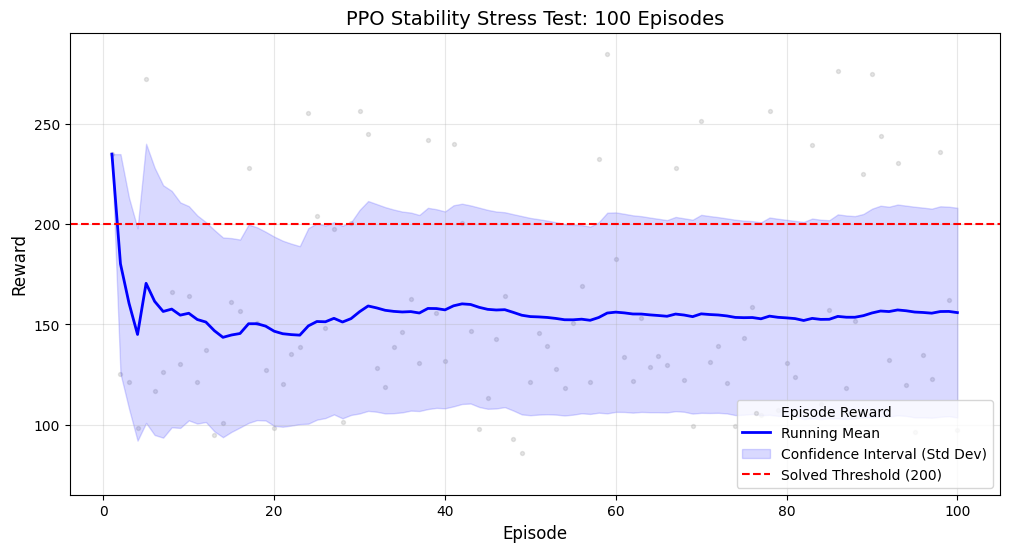

In [6]:
# Convergence Plot
episodes = np.arange(1, len(rewards) + 1)
running_mean = np.cumsum(rewards) / episodes
running_std = np.array([np.std(rewards[:i]) for i in episodes])

plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, color='gray', alpha=0.2, s=8, label='Episode Reward')
plt.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
plt.fill_between(episodes, running_mean - running_std, running_mean + running_std, color='blue', alpha=0.15, label='Confidence Interval (Std Dev)')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

plt.title(f"{SELECTED_ALGORITHM.upper()} Stability Stress Test: {EVALUATION_EPISODES} Episodes", fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
def load_monitor_logs(algorithm):
    all_seeds = []

    for seed in SEEDS:
        path = f"{LOG_DIR}/{algorithm}_seed{seed}/*monitor.csv"
        file = glob.glob(path)[0]
        df = pd.read_csv(file, skiprows=1)
        df["seed"] = seed
        all_seeds.append(df)

    return pd.concat(all_seeds, ignore_index=True)


In [10]:
def plot_episode_length(df, title):
    grouped = df.groupby("l").agg({"l": "mean"})
    plt.figure(figsize=(10,5))
    plt.plot(grouped.index, grouped["l"])
    plt.title(title)
    plt.xlabel("Environment steps")
    plt.ylabel("Episode length")
    plt.show()

plot_episode_length(dqn_logs, "DQN — Episode Length")
plot_episode_length(ppo_logs, "PPO — Episode Length")



NameError: name 'dqn_logs' is not defined

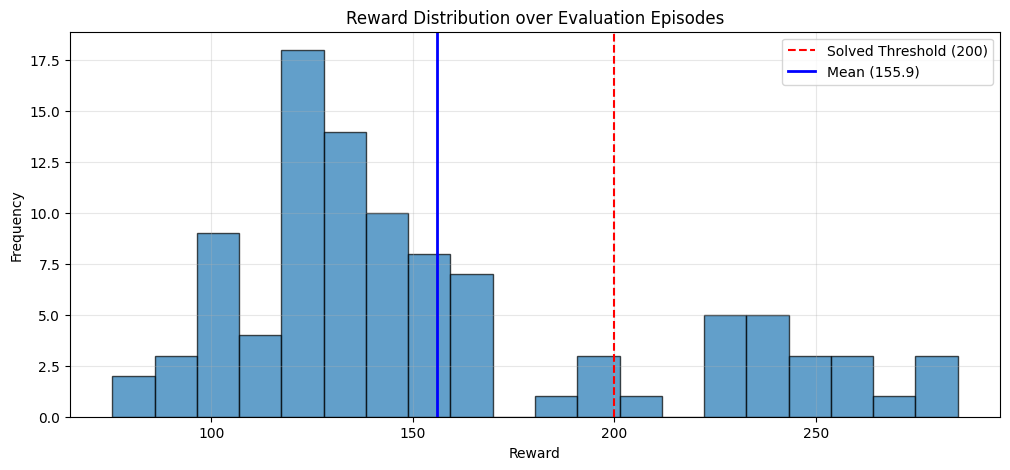

In [7]:
# Reward Distribution Histogram
plt.figure(figsize=(12, 5))
plt.hist(rewards, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.axvline(x=np.mean(rewards), color='blue', linestyle='-', linewidth=2, label=f'Mean ({np.mean(rewards):.1f})')
plt.title('Reward Distribution over Evaluation Episodes')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Saved visualization to: ./outputs_ppo/ppo_lunarlander.gif


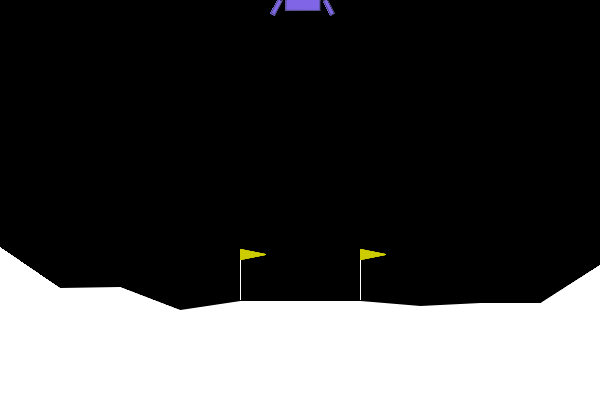

In [8]:
# GIF Visualization
visualization_environment = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array")

frames = []
obs, info = visualization_environment.reset()
done = False

while not done:
    action, _ = MODEL.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = visualization_environment.step(action)
    done = terminated or truncated
    frames.append(visualization_environment.render())

visualization_environment.close()

gif_path = os.path.join(OUTPUT_DIR, SELECTED_ALGORITHM + "_lunarlander.gif")
imageio.mimsave(gif_path, frames, fps=30)

print(f"Saved visualization to: {gif_path}")
Image(filename=gif_path)

---

## Additional plot cells can go below
